In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings('ignore')


In [3]:

def prepare_data(data):
    """Prepare data for modeling with train/validation/test split"""
    # Encode categorical variables
    le = LabelEncoder()
    data['Gender'] = le.fit_transform(data['Gender'])
    data['CKD_Stage'] = le.fit_transform(data['CKD_Stage'])
    
    # Split features and target
    X = data.drop(['CKD_Stage'], axis=1)
    y = data['CKD_Stage']
    
    # First split: separate test set (20% of data)
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Second split: divide remaining data into train and validation
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test

In [4]:


def evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test, model_name):
    """Train and evaluate model with detailed metrics"""
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    # Print results
    print(f"\n{'-'*20} {model_name} Results {'-'*20}")
    
    print("\nValidation Set Results:")
    print(classification_report(y_val, y_val_pred))
    
    print("\nTest Set Results:")
    print(classification_report(y_test, y_test_pred))
    
    # Confusion Matrices
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    cm_val = confusion_matrix(y_val, y_val_pred)
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix (Validation) - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.subplot(1, 2, 2)
    cm_test = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix (Test) - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()
    
    # Cross-validation score on training data
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"\nCross-validation scores: {cv_scores}")
    print(f"Average CV score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    
    return model, y_val_pred, y_test_pred

In [5]:


def plot_roc_curves(models, X_val, y_val, title="Validation"):
    """Plot ROC curves for all models"""
    plt.figure(figsize=(10, 8))
    
    # Binarize the output
    y_bin = label_binarize(y_val, classes=np.unique(y_val))
    n_classes = y_bin.shape[1]
    
    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_val)
            
            # Compute ROC curve and ROC area for each class
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            
            for i in range(n_classes):
                fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])
            
            # Compute micro-average ROC curve and ROC area
            fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
            roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
            
            plt.plot(fpr["micro"], tpr["micro"], label=f'{name} (AUC = {roc_auc["micro"]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves ({title} Set)')
    plt.legend(loc="lower right")
    plt.show()

In [6]:
def plot_feature_importance(model, feature_names, X_train, y_train, model_name):
    """Plot feature importance for each model"""
    plt.figure(figsize=(10, 6))
    
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif isinstance(model, LogisticRegression):
        importances = np.abs(model.coef_).mean(axis=0)
    elif isinstance(model, SVC) and model.kernel == 'linear':
        importances = np.abs(model.coef_[0])
    else:
        from sklearn.inspection import permutation_importance
        result = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42)
        importances = result.importances_mean
    
    indices = np.argsort(importances)[::-1]
    plt.title(f'Feature Importances - {model_name}')
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
    plt.tight_layout()
    plt.show()

Loading the CKD dataset...

Dataset Shape: (60000, 10)

Feature Statistics:
                Age    Creatinine           GFR    Blood_Urea    Hemoglobin  \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean      64.449873      1.797974     51.926808     55.295065     12.375473   
std       15.032082      1.019537     32.562436     42.084995      1.977899   
min       18.000000      0.600000     10.400000      7.000000      7.400000   
25%       54.400000      0.960000     24.800000     23.300000     10.900000   
50%       64.600000      1.510000     44.950000     39.800000     12.200000   
75%       75.000000      2.470000     76.600000     74.200000     13.700000   
max       95.000000      4.000000    153.000000    200.000000     17.500000   

          Potassium        Sodium  Gender_encoded  
count  60000.000000  60000.000000    60000.000000  
mean       4.310310    138.978608        0.446983  
std        0.303382      3.151594        0.497185  
min 

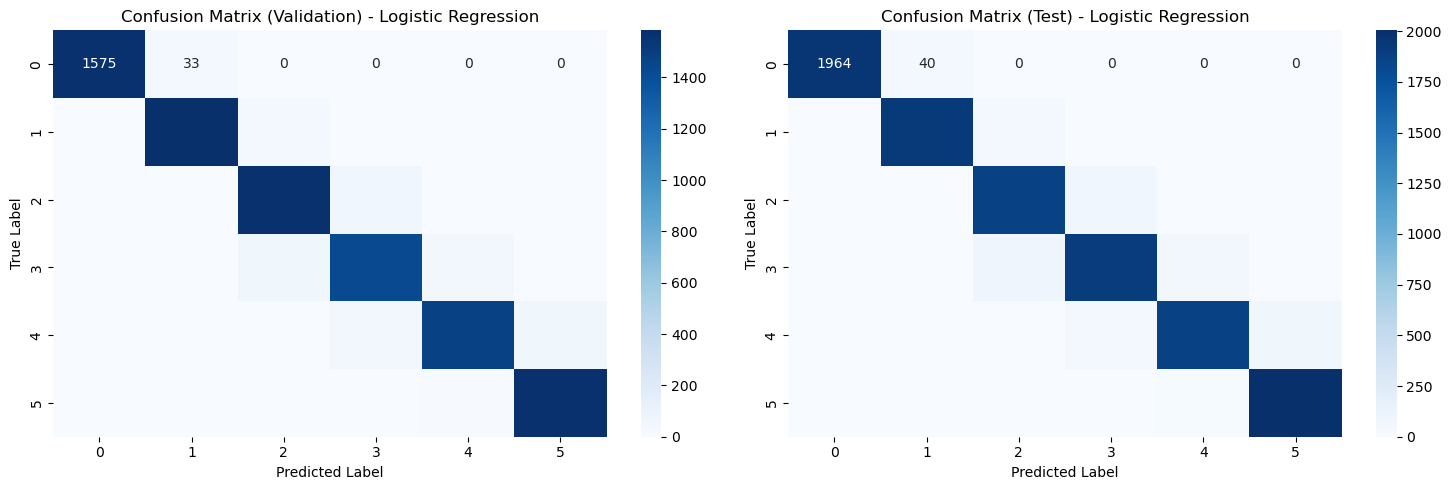


Cross-validation scores: [0.95833333 0.96328125 0.96484375 0.96236979 0.9640625 ]
Average CV score: 0.963 (+/- 0.005)

Feature importance for Logistic Regression:


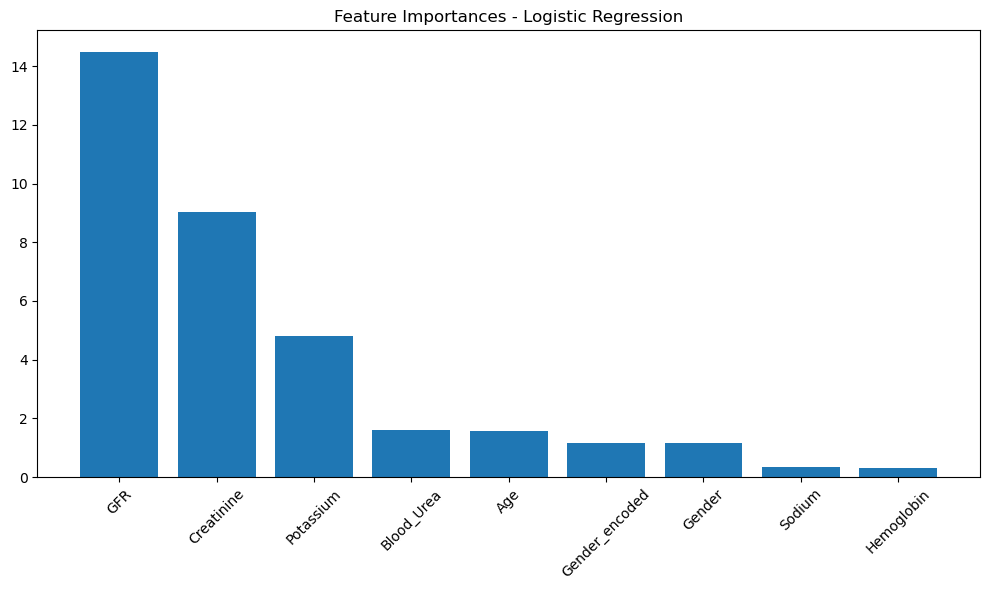


Training and evaluating Support Vector Machine...

-------------------- Support Vector Machine Results --------------------

Validation Set Results:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1608
           1       0.97      0.96      0.97      1625
           2       0.93      0.96      0.94      1638
           3       0.94      0.94      0.94      1549
           4       0.98      0.94      0.96      1595
           5       0.97      1.00      0.98      1585

    accuracy                           0.96      9600
   macro avg       0.96      0.96      0.96      9600
weighted avg       0.96      0.96      0.96      9600


Test Set Results:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      2004
           1       0.97      0.97      0.97      1959
           2       0.93      0.96      0.94      1946
           3       0.94      0.93      0.94      2068
           4     

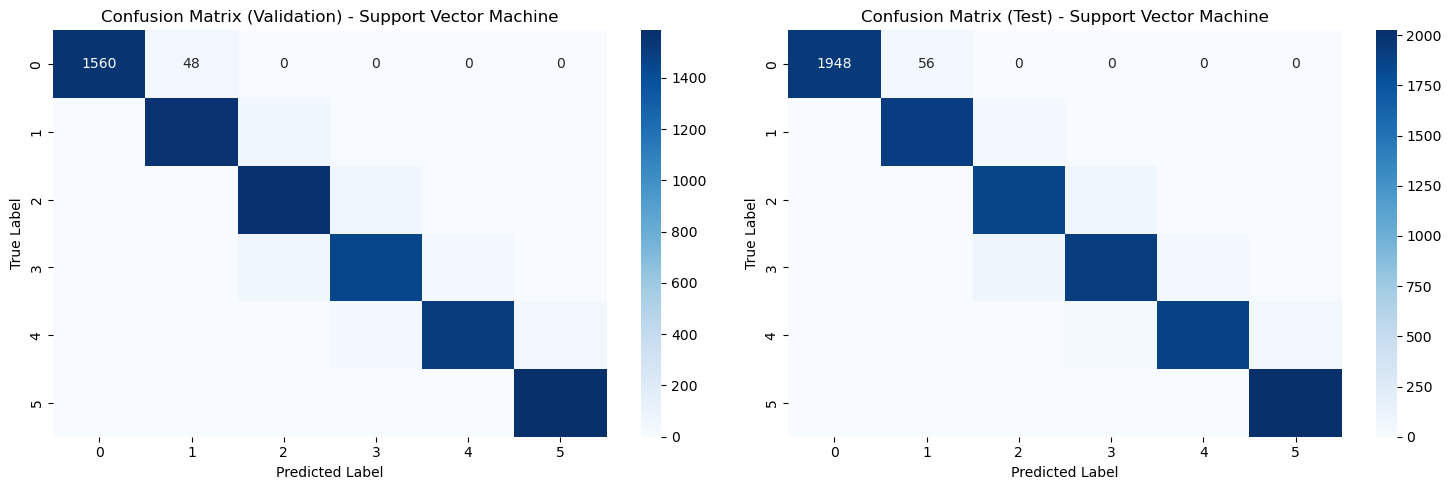


Cross-validation scores: [0.95820313 0.96184896 0.96080729 0.96002604 0.96236979]
Average CV score: 0.961 (+/- 0.003)

Feature importance for Support Vector Machine:


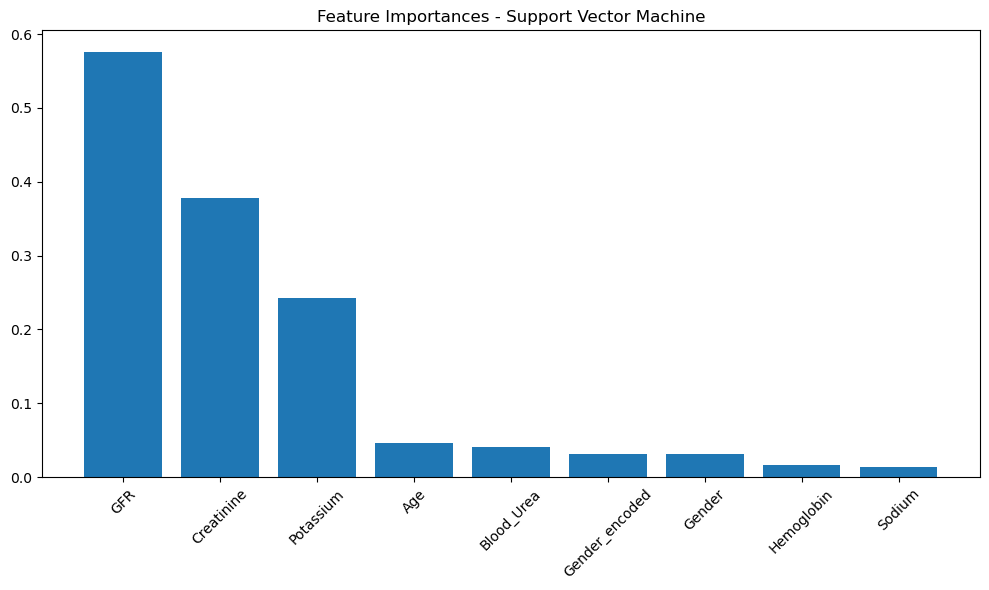


Training and evaluating Decision Tree...

-------------------- Decision Tree Results --------------------

Validation Set Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1608
           1       1.00      1.00      1.00      1625
           2       1.00      1.00      1.00      1638
           3       1.00      1.00      1.00      1549
           4       1.00      1.00      1.00      1595
           5       1.00      1.00      1.00      1585

    accuracy                           1.00      9600
   macro avg       1.00      1.00      1.00      9600
weighted avg       1.00      1.00      1.00      9600


Test Set Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2004
           1       1.00      1.00      1.00      1959
           2       1.00      1.00      1.00      1946
           3       1.00      1.00      1.00      2068
           4       1.00      1.00  

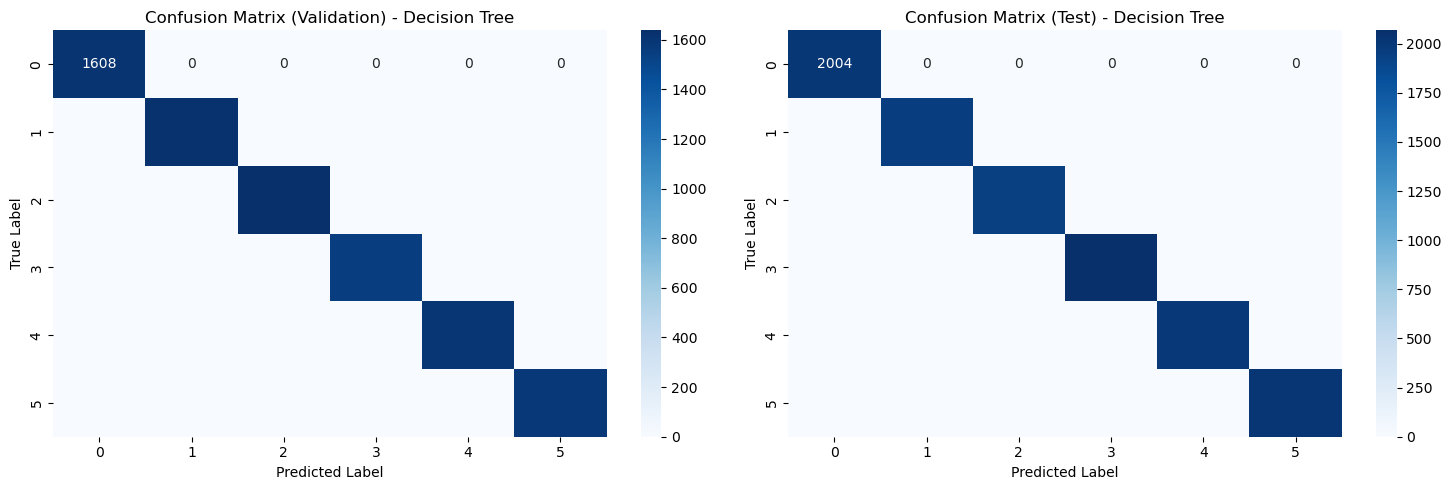


Cross-validation scores: [1. 1. 1. 1. 1.]
Average CV score: 1.000 (+/- 0.000)

Feature importance for Decision Tree:


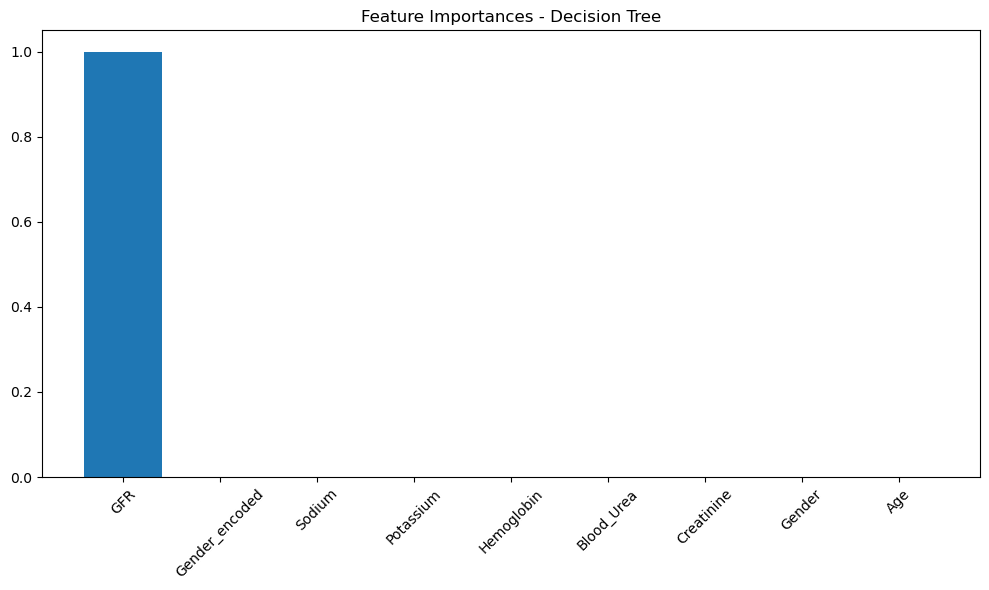


Training and evaluating Random Forest...

-------------------- Random Forest Results --------------------

Validation Set Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1608
           1       1.00      1.00      1.00      1625
           2       1.00      1.00      1.00      1638
           3       1.00      1.00      1.00      1549
           4       1.00      1.00      1.00      1595
           5       1.00      1.00      1.00      1585

    accuracy                           1.00      9600
   macro avg       1.00      1.00      1.00      9600
weighted avg       1.00      1.00      1.00      9600


Test Set Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2004
           1       1.00      1.00      1.00      1959
           2       1.00      1.00      1.00      1946
           3       1.00      1.00      1.00      2068
           4       1.00      1.00  

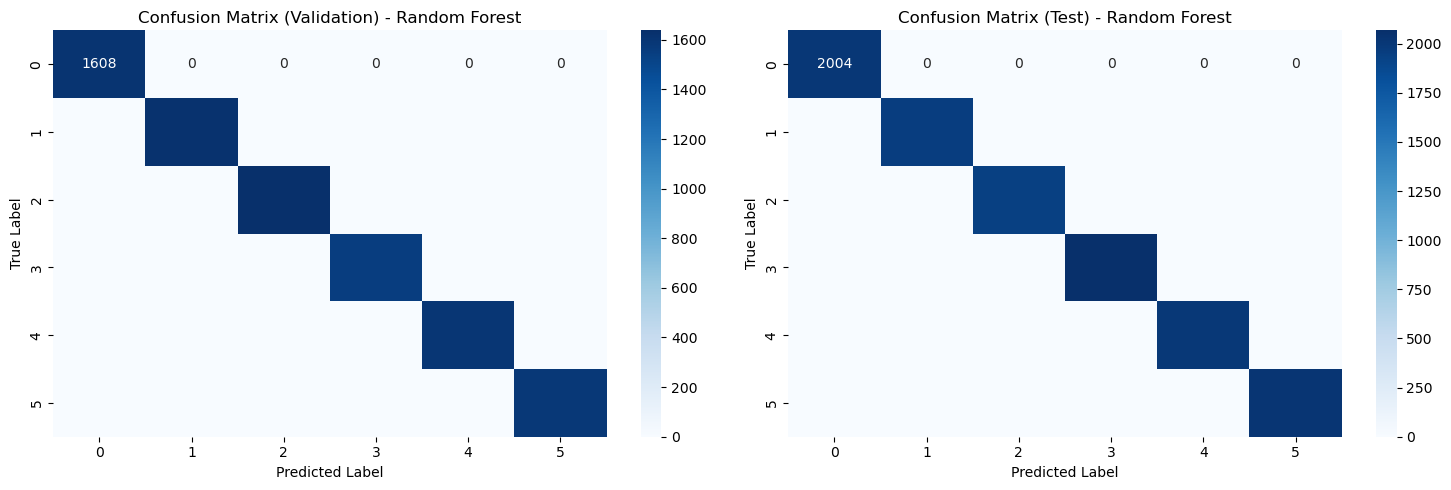


Cross-validation scores: [1. 1. 1. 1. 1.]
Average CV score: 1.000 (+/- 0.000)

Feature importance for Random Forest:


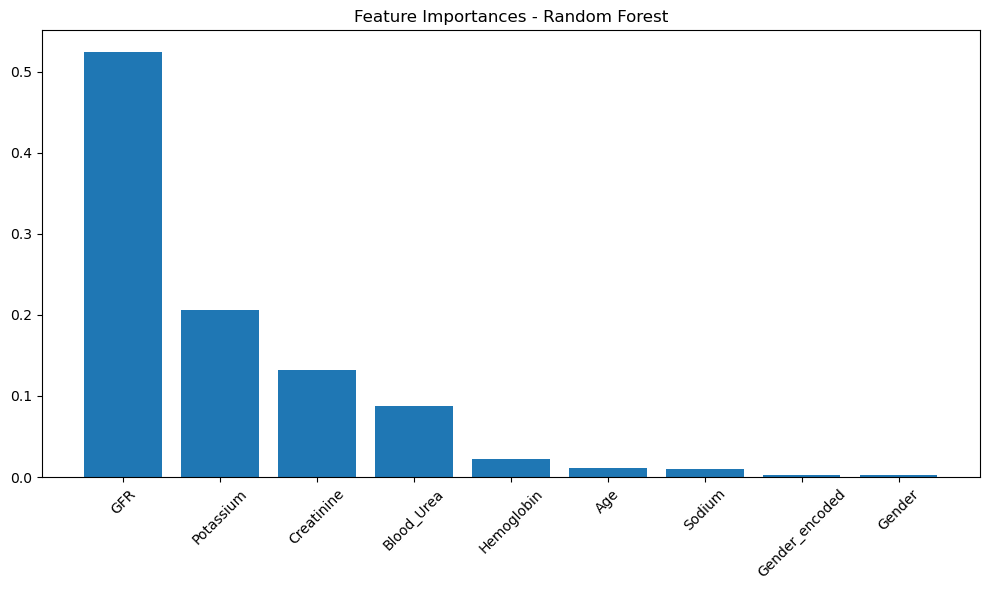


Training and evaluating K-Nearest Neighbors...

-------------------- K-Nearest Neighbors Results --------------------

Validation Set Results:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1608
           1       0.90      0.92      0.91      1625
           2       0.90      0.89      0.89      1638
           3       0.92      0.91      0.91      1549
           4       0.96      0.94      0.95      1595
           5       0.98      1.00      0.99      1585

    accuracy                           0.94      9600
   macro avg       0.94      0.94      0.94      9600
weighted avg       0.94      0.94      0.94      9600


Test Set Results:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2004
           1       0.91      0.94      0.92      1959
           2       0.91      0.91      0.91      1946
           3       0.93      0.91      0.92      2068
           4       0.96

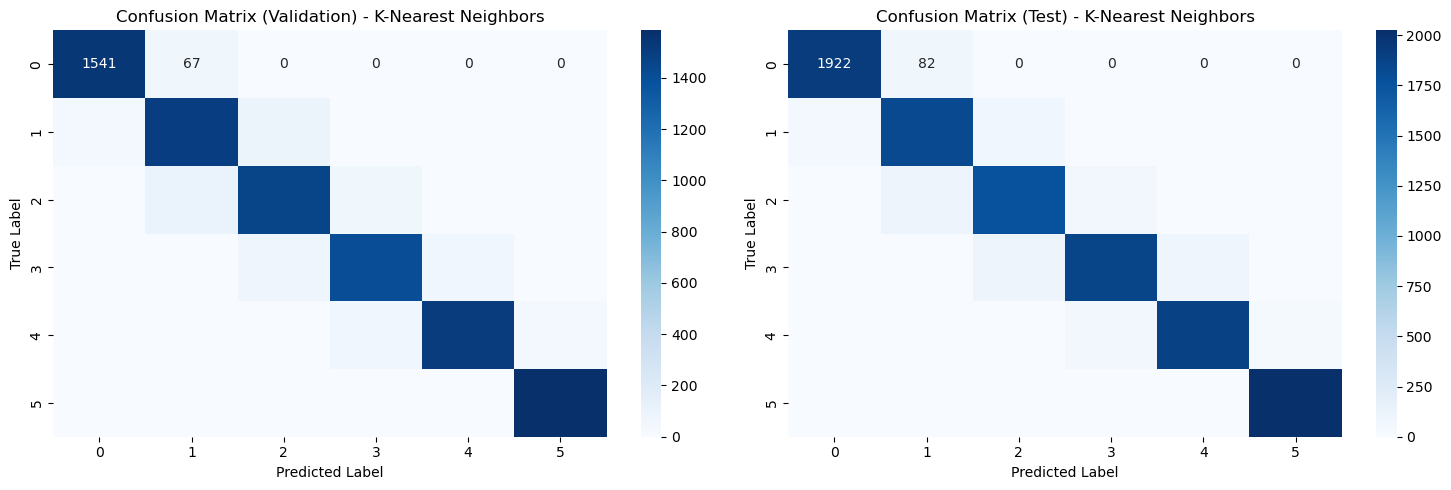


Cross-validation scores: [0.93528646 0.93554688 0.93828125 0.93502604 0.9375    ]
Average CV score: 0.936 (+/- 0.003)

Feature importance for K-Nearest Neighbors:


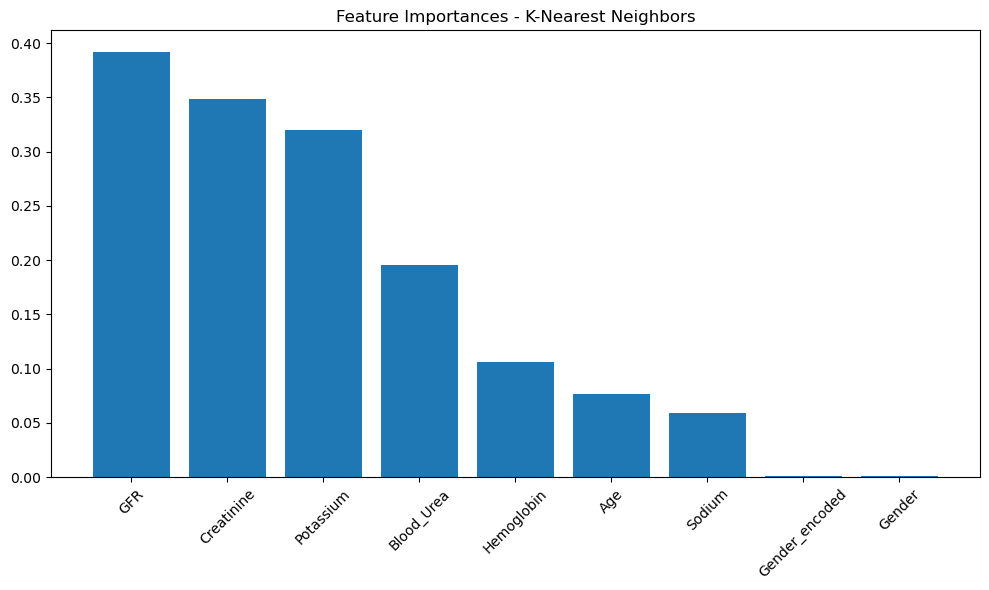


Generating ROC curves...


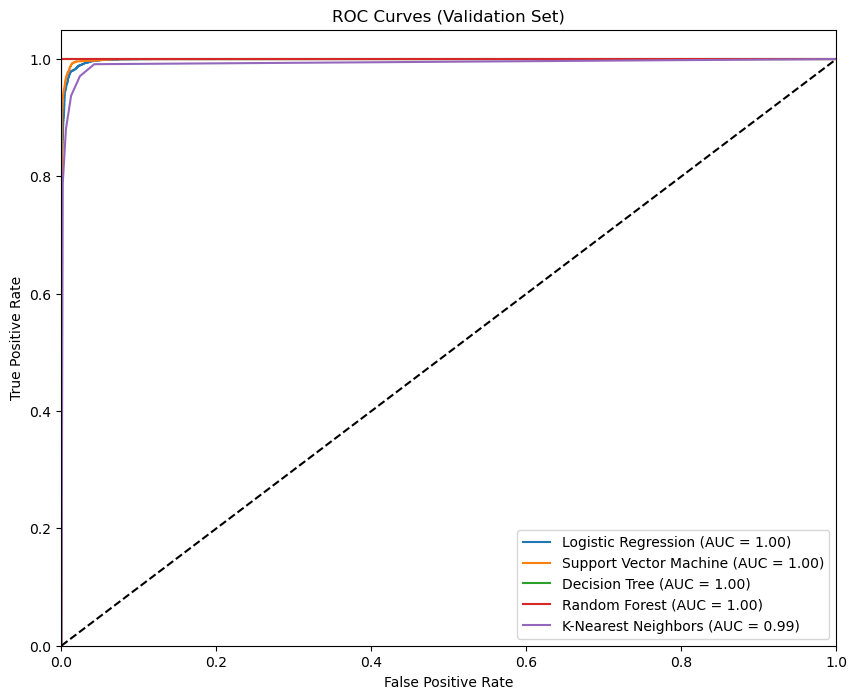

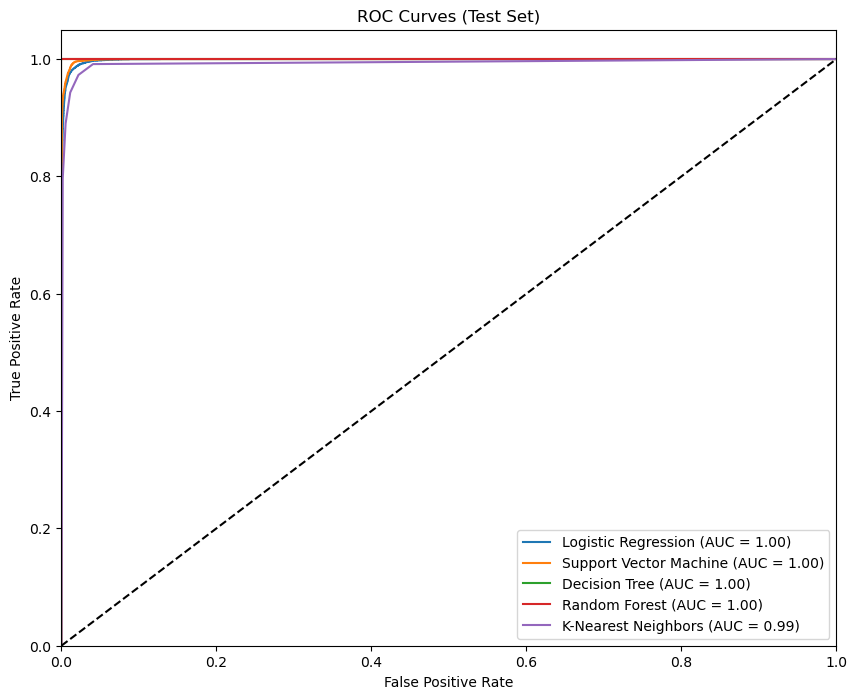


Model Performance Comparison:
                    Model  Validation Accuracy  Test Accuracy
2           Decision Tree             1.000000       1.000000
3           Random Forest             1.000000       1.000000
1  Support Vector Machine             0.962917       0.963250
0     Logistic Regression             0.960729       0.961167
4     K-Nearest Neighbors             0.937396       0.943000

Results saved to 'model_performance_comparison.csv'


In [7]:

def main():
    # Load the dataset
    print("Loading the CKD dataset...")
    data = pd.read_csv('ckd_balanced_dataset.csv')
    
    # Print initial dataset information
    print("\nDataset Shape:", data.shape)
    print("\nFeature Statistics:")
    print(data.describe())
    
    # Prepare data
    print("\nPreparing data splits...")
    X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test = prepare_data(data)
    
    # Define models
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Support Vector Machine': SVC(kernel='rbf', probability=True),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'K-Nearest Neighbors': KNeighborsClassifier()
    }
    
    # Train and evaluate models
    trained_models = {}
    feature_names = data.drop(['CKD_Stage'], axis=1).columns
    
    for name, model in models.items():
        print(f"\nTraining and evaluating {name}...")
        trained_model, y_val_pred, y_test_pred = evaluate_model(
            model, X_train_scaled, X_val_scaled, X_test_scaled,
            y_train, y_val, y_test, name
        )
        
        trained_models[name] = trained_model
        
        print(f"\nFeature importance for {name}:")
        plot_feature_importance(trained_model, feature_names, X_train_scaled, y_train, name)
    
    # Plot ROC curves
    print("\nGenerating ROC curves...")
    plot_roc_curves(trained_models, X_val_scaled, y_val, "Validation")
    plot_roc_curves(trained_models, X_test_scaled, y_test, "Test")
    
    # Compare model performances
    val_performances = {name: classification_report(y_val, model.predict(X_val_scaled), output_dict=True)['accuracy']
                       for name, model in trained_models.items()}
    test_performances = {name: classification_report(y_test, model.predict(X_test_scaled), output_dict=True)['accuracy']
                        for name, model in trained_models.items()}
    
    performance_comparison = pd.DataFrame({
        'Model': list(trained_models.keys()),
        'Validation Accuracy': list(val_performances.values()),
        'Test Accuracy': list(test_performances.values())
    })
    
    print("\nModel Performance Comparison:")
    print(performance_comparison.sort_values('Test Accuracy', ascending=False))
    
    # Save results
    performance_comparison.to_csv('model_performance_comparison.csv', index=False)
    print("\nResults saved to 'model_performance_comparison.csv'")

if __name__ == "__main__":
    main()